# Khóa học VIA - Bài học: Huấn luyện mạng phân loại biển báo giao thông

<img width="120px" src="https://via.makerviet.org/media/via-logo.png">

**Website:** https://via.makerviet.org/

Nội dung khóa học này được tạo và phân phối miễn phí cho người học bởi các thành viên của dự án VIA. Toàn bộ bản quyền các nội dung trong khóa học thuộc về [MakerHanoi](https://www.facebook.com/makerhanoi/).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/makerhanoi/via-course-ai/blob/master/notebooks/06-Huan-luyen-phan-loai-bien-bao.ipynb)


Ở bài trước, chúng ta đã thành công áp dụng kết hợp thuật toán phát hiện biển báo sử dụng màu sắc và mạng phân loại biển báo giao thông đã được huấn luyện sẵn để khoanh vùng chính xác 6 loại biển báo. Notebook này sẽ hướng dẫn các bạn huấn luyện lại mạng phân loại biển báo từ đầu, nhằm cung cấp thêm kiến thức để các bạn dễ dàng chỉnh sửa mạng phân loại biển báo cho các bài toán khác.

In [ ]:
# Khai báo thư viện Tensorflow
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
# Khai báo các thư viện cần thiết khác
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import glob
import time
import cv2
import os

**Các siêu tham số:**

In [ ]:
num_epochs = 20 # Số lượng lần huấn luyện đi qua hết 1 vòng tập dữ liệu
learning_rate = 0.001 # Tỷ lệ học của thuật toán
batch_size = 64

## I. Chuẩn bị dữ liệu

Chúng tôi đã chuẩn bị tập dữ liệu gồm 6 loại biển báo khác nhau và một lớp đối tượng không là biển báo (unknown), bao gồm khoảng 18000 ảnh. Các lớp đối tượng gồm có: 

+ /00_unknown: Không thuộc loại biển báo nào
+ /01_left: Biển rẽ trái
+ /02_no_left: Biển cấm rẽ trái
+ /03_right: Biển rẽ phải
+ /04_no_right: Biển cấm rẽ phải
+ /05_straight: Biển đi thẳng
+ /06_stop: Biển cấm (dừng)

Bộ dữ liệu được chuẩn bị từ [VIA Dataset 1.0](https://via.makerviet.org/vi/docs/datasets/via-datasets-1-0/), dữ liệu [ImageNet](https://image-net.org/) và từ giả lập chạy xe.

### Tải dữ liệu

In [ ]:
# Xóa dữ liệu cũ
!rm -rf /content/data
!rm -rf /content/data_raw

In [ ]:
# Tải và giải nén dữ liệu
!mkdir /content/data_raw
%cd /content/data_raw
!gdown  https://drive.google.com/uc?id=1zsLnS1uh1mS5l0vLC4YuXItHmiPR7KG9
!unzip -qo traffic_sign_classification_data_v2.zip

/content/data_raw
Downloading...
From: https://drive.google.com/uc?id=1zsLnS1uh1mS5l0vLC4YuXItHmiPR7KG9
To: /content/data_raw/traffic_sign_classification_data_v2.zip
100% 192M/192M [00:01<00:00, 133MB/s]


In [ ]:
%cd /content/data_raw
all_img_paths = list(paths.list_images("."))
print(all_img_paths[:10])

/content/data_raw
['./02_no_left/00338.jpg', './02_no_left/06118.jpg', './02_no_left/00032.jpg', './02_no_left/06132.jpg', './02_no_left/03292.jpg', './02_no_left/09116.jpg', './02_no_left/00163.jpg', './02_no_left/02433.jpg', './02_no_left/06450.jpg', './02_no_left/06327.jpg']


### Trộn dữ liệu và hiện ảnh

In [ ]:
# Trộn dữ liệu và hiện các hình ảnh
np.random.seed(0)
random.shuffle(all_img_paths)
print(all_img_paths[:5])

['./00_unknown/32542.jpg', './00_unknown/362527715_e98caca26f.jpg', './06_stop/00416.jpg', './06_stop/09529.jpg', './00_unknown/data-tfs-00005333.jpg']


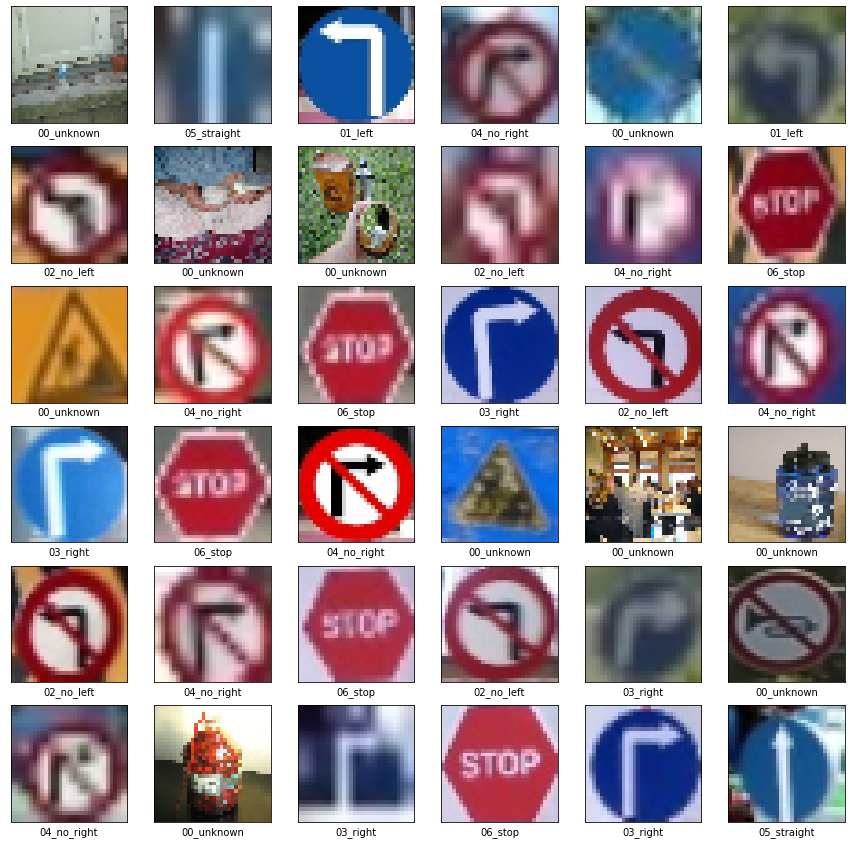

In [ ]:
# trực quan hóa hình ảnh
plt.figure(figsize=(15,15))
for i in range(36):
    image_path = np.random.choice(all_img_paths)
    image = plt.imread(image_path)
    image = cv2.resize(image, (32, 32))
    # hiển thị cả label
    label = image_path.split("/")[1]
    plt.subplot(6, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

### Chia dữ liệu

Thông thường, với bài toán huấn luyện mô hình trí tuệ nhân tạo, chúng ta thường chia dữ liệu làm 3 tập (tập huấn luyện, tập giám sát, và tập kiểm tra), hoặc 2 tập (tập huấn luyện và tập giám sát).

Để đơn giản, chúng tôi chia dữ liệu chỉ thành hai tập con: tập huấn luyện - training set (85%) và tập giám sát - validation set (15%).

Sau khi tách, cấu trúc tập dữ liệu của chúng ta sẽ giống như sau:

```
/content
    + /train
        + /00_unknown
        + /01_left
        + /02_no_left
        + /03_right
        + /04_no_right
        + /05_straight
        + /06_stop
    + /val
        + /00_unknown
        + /01_left
        + /02_no_left
        + /03_right
        + /04_no_right
        + /05_straight
        + /06_stop
```


In [ ]:
!rm -rf /content/data/

In [ ]:
val_ratio = 0.20
train_dir = "/content/data/train"
val_dir = "/content/data/val"

In [ ]:
val_imgs = int(len(all_img_paths) * val_ratio)
train_imgs = len(all_img_paths) - val_imgs
train_img_paths = all_img_paths[:train_imgs]
test_img_paths = all_img_paths[train_imgs:]

In [ ]:
# Hàm dưới đây sẽ copy hình ảnh vào nhưng folder con để cấu trúc tập dữ liệu của chúng ta giống như mô tả ở trên
def copy_images(img_paths, output_dir):
	for imagePath in img_paths:
		# lấy label từ imagePath
		label = imagePath.split("/")[1]

		# Kiểm tra nếu đường dẫn cho label chưa tồn tại thì mới tạo
		imageDir = os.path.join(output_dir, label)
		if not os.path.exists(imageDir):
			os.makedirs(imageDir)

		# sao chép hình ảnh đến folder chúng ta sẽ dùng để huấn luyện
		shutil.copy2(imagePath, imageDir)

In [ ]:
copy_images(train_img_paths, train_dir)
copy_images(test_img_paths, val_dir)

### Chuẩn bị trình sinh dữ liệu

Chúng tôi sẽ sử dụng Keras `ImageDataGenerator` để cung cấp dữ liệu huấn luyện. Hình ảnh sẽ được tải tự động bởi trình tạo, được biến đổi bằng các phương pháp tăng cường ảnh và thay đổi kích thước bằng kích thước của đầu vào mô hình (32x32).


In [ ]:
# chuyển đường dẫn hiện tại đến /content/data
%cd /content/data

/content/data


In [ ]:
# khởi tạo data generators (trình sinh dữ liệu)
train_aug = ImageDataGenerator(rescale=1/255.,
								horizontal_flip=False,
								vertical_flip=False,
								brightness_range=[0.9, 1.1],
								zoom_range=0.1,
								width_shift_range=0.2,
								height_shift_range=0.2,
								channel_shift_range=0.5)

val_aug = ImageDataGenerator(rescale=1/255.,
                             horizontal_flip=False,
							 vertical_flip=False,)

print("Training set")
train_gen = train_aug.flow_from_directory(train_dir,
    class_mode="categorical",
    target_size=(32, 32),
	color_mode="rgb",
	shuffle=True,
	batch_size=batch_size
)

print("Validation set")
val_gen = train_aug.flow_from_directory(val_dir,
    class_mode="categorical",
    target_size=(32, 32),
	color_mode="rgb",
	shuffle=False,
	batch_size=batch_size
)
num_classes = len(train_gen.class_indices.keys())
print("Set number of classes to {}".format(num_classes))

Training set
Found 14463 images belonging to 7 classes.
Validation set
Found 3615 images belonging to 7 classes.
Set number of classes to 7


In [ ]:
# Lấy tên label (tên nhãn) rồi nhập vào file labels.txt
print(train_gen.class_indices)
labels = '\n'.join(sorted(train_gen.class_indices.keys()))
with open('labels.txt', 'w') as f:
    f.write(labels)

{'00_unknown': 0, '01_left': 1, '02_no_left': 2, '03_right': 3, '04_no_right': 4, '05_straight': 5, '06_stop': 6}


In [ ]:
# Lưu số lượng trong tập training (huấn luyện) và tập giám sát (validation)
num_train_samples = len(list(paths.list_images("train")))
num_val_samples = len(list(paths.list_images("val")))
print("Train: {} images, Val: {} images".format(num_train_samples, num_val_samples))

Train: 14463 images, Val: 3615 images


## II. Huấn luyện

Trong phần này, chúng tôi xây dựng và đào tạo mô hình phân loại ảnh dựa trên dữ liệu đã chuẩn bị. Hàm `build_model` bên dưới giúp chúng ta chuẩn bị mô hình. Chúng tôi sử dụng LeNet làm xương sống để trích xuất các đặc trưng ảnh, sau đó đính kèm một lớp `Flatten()` và một số lớp fully connected hơn để phân loại.


In [ ]:
# chuyển đến đường dẫn /content
%cd /content

/content


In [ ]:
# Xây dựng kiến trúc mô hình
def build_model():
    classifier = Sequential()
    classifier.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(32, 32, 3)))
    classifier.add(MaxPool2D(strides=2))
    classifier.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    classifier.add(MaxPool2D(strides=2))
    classifier.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    classifier.add(MaxPool2D(strides=2))
    classifier.add(Flatten())
    classifier.add(Dropout(0.5))
    classifier.add(Dense(128, activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dense(num_classes, activation='softmax'))
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(learning_rate),
                          metrics=["accuracy"])
    return classifier

Chúng ta thực hiện huấn luyện mô hình theo các tham số đã cài đặt trước:

In [ ]:
# xây dựng kiến trúc mô hình
classification_model = build_model()

# khởi tạo hàm callback để lưu trọng số tốt nhất trong quá trình huấn luyện
best_model_path = "best_model_checkpoint.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start = time.time()
history = classification_model.fit(train_gen,
    steps_per_epoch=num_train_samples // batch_size,
    validation_data=val_gen,
    validation_steps=num_val_samples // batch_size,
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback]
)
print("Total training time: ", time.time()-start)

# gọi ra model với trọng số (weights) tốt nhất
classification_model.load_weights(best_model_path)

Epoch 1/20
225/225 [==============================] - 44s 155ms/step - loss: 1.3889 - accuracy: 0.4048 - val_loss: 0.8079 - val_accuracy: 0.6897
Epoch 2/20
225/225 [==============================] - 35s 154ms/step - loss: 0.6646 - accuracy: 0.7366 - val_loss: 0.3246 - val_accuracy: 0.8502
Epoch 3/20
225/225 [==============================] - 38s 170ms/step - loss: 0.4543 - accuracy: 0.8285 - val_loss: 0.2279 - val_accuracy: 0.9425
Epoch 4/20
225/225 [==============================] - 34s 153ms/step - loss: 0.3747 - accuracy: 0.8574 - val_loss: 0.1811 - val_accuracy: 0.9487
Epoch 5/20
225/225 [==============================] - 38s 169ms/step - loss: 0.3111 - accuracy: 0.8904 - val_loss: 0.1251 - val_accuracy: 0.9634
Epoch 6/20
225/225 [==============================] - 38s 169ms/step - loss: 0.2803 - accuracy: 0.9050 - val_loss: 0.1073 - val_accuracy: 0.9676
Epoch 7/20
225/225 [==============================] - 38s 170ms/step - loss: 0.2373 - accuracy: 0.9231 - val_loss: 0.1973 - val_ac

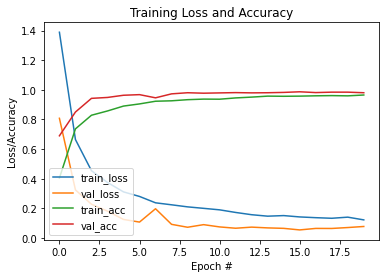

In [ ]:
# trực quan hóa loss và accuracy trên cả 2 tập training và validation
N = len(history.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
eval_result = classification_model.evaluate(val_gen)
val_accuracy = eval_result[1]
print("Model accuracy on validation set: {}".format(val_accuracy))

57/57 [==============================] - 7s 114ms/step - loss: 0.0573 - accuracy: 0.9853
Model accuracy on validation set: 0.9853388667106628


## III. Chuyển đổi mô hình.

Để có một mô hình có thể được sử dụng với OpenCV DNN, chúng tôi chuyển đổi mô hình được đào tạo thành [định dạng ONNX] (https://onnx.ai/).

In [ ]:
!pip install -U tf2onnx

In [ ]:
import onnx
import tf2onnx

onnx_model, _ = tf2onnx.convert.from_keras(classification_model, opset=11, output_path="traffic_sign_classifier.onnx")
output_names = [n.name for n in onnx_model.graph.output]
print("Output names: ", output_names)

Bây giờ bạn có thể nhìn vào thanh bên trái, mở trình duyệt tệp và tải xuống mô hình `traffic_sign_detection.onnx`. Mô hình này có thể được sử dụng với dự án VIA.